In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import matplotlib.pyplot as plt
from IPython.display import display
import shap
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from comparers import ModelComparer, plot_decision_boundary
from util import RuleClassifier, get_complexity, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate, group_metrics
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering, eval_clusterings, plot_2d_with_boundaries

In [2]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X, y, feature_names, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [5]:
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection
filter_lines = lambda handles, labels: zip(*filter(lambda t: not isinstance(t[0], Line2D), zip(handles, labels)))
filter_paths = lambda handles, labels: zip(*filter(lambda t: not isinstance(t[0], PathCollection), zip(handles, labels)))

# Generate Explanations

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('explanations/indiv.log_odds.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('explanations/diffclf.log_odds.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 301it [00:19,  9.23it/s]                         
Exact explainer: 301it [00:13,  5.66it/s]                         


CPU times: user 31.8 s, sys: 292 ms, total: 32.1 s
Wall time: 33.4 s


In [7]:
%%time
node = make_clustering(comparer, indiv_shap_values, diffclf_shap_values,
                       feature_precisions=feature_precisions)
for class_name in comparer.class_names:
    print(class_name)
    node.focus_class = class_name
    node.calculate_counterfactuals()
with open(f'explanations/clustering.pickle', 'wb') as f:
    pickle.dump(node.state, f)

(0, 0)
(0, 1)
(1, 0)
(1, 1)
CPU times: user 11min 42s, sys: 6.4 s, total: 11min 49s
Wall time: 13min 7s


In [6]:
with open('explanations/diffclf.log_odds.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)
with open('explanations/indiv.log_odds.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)
with open(f'explanations/clustering.pickle', 'rb') as f:
    state = pickle.load(f)
node = make_clustering(comparer, indiv_shap_values, diffclf_shap_values, focus_class=None,
                       feature_precisions=feature_precisions, state=state)

# Interpretation

In [7]:
node = node.root
node.focus_class = None
classes = ['1']

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

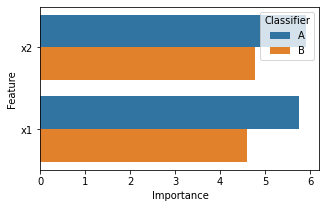

In [8]:
_, feature_importances_a = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
_, feature_importances_b = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
feature_order, _ = calc_feature_order(indiv_shap_values)
feature_idx = pd.Index(feature_names, name='Feature')
feature_importances_a = pd.Series(feature_importances_a.values, index=feature_idx, name='Importance')
feature_importances_b = pd.Series(feature_importances_b.values, index=feature_idx, name='Importance')
feature_importances = pd.concat({'A': feature_importances_a, 'B': feature_importances_b}, names=['Classifier'])
feature_importances = pd.DataFrame(feature_importances, columns=['Importance']).reset_index()
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(orient='h', data=feature_importances, y='Feature', x='Importance', hue='Classifier', order=feature_names[feature_order], ax=ax)

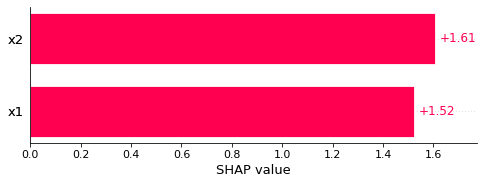

In [9]:
plot_feature_importance_bar(node.diff_feature_importances, feature_order=node.diff_feature_order)

In [10]:
from clustering import plot_indiv_dependence_curve_comparison_for_feature, _DEFAULT_FIGSIZE

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


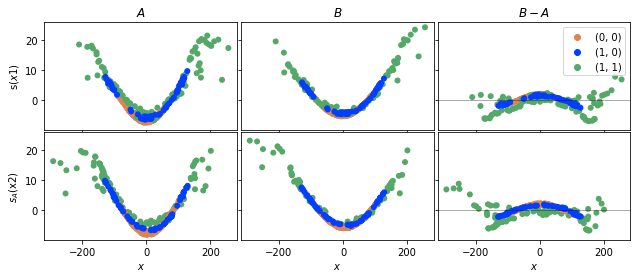

In [11]:
figsize = _DEFAULT_FIGSIZE
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3*figsize[0], 2*figsize[1]), squeeze=False, constrained_layout=True, sharex='all', sharey='all')
node.plot_indiv_feature_dependence('x1', classes=classes, axs=axs[0:1].T)
node.plot_indiv_feature_dependence('x2', classes=classes, axs=axs[1:2].T)
axs = plt.gca().figure.axes
axs[0].set_ylabel('s($x1$)')
axs[0].set_title('$A$')
axs[1].set_title('$B$')
axs[2].set_title('$B-A$')
for ax in axs[3:]:
    ax.set_title(None)
    ax.set_xlabel('$x$')
axs[2].legend()
plt.savefig('figures/gaussian-indiv-depplots.pdf', bbox_inches='tight', pad_inches=0)

B underestimates both features' effects for low and high feature values.

In [12]:
node = node.root
node.focus_class = '(1, 0)'
classes = ['(0, 0)', '(1, 0)', '(1, 1)']

In [13]:
from clustering import plot_dependence_curves_for_nodes

In [14]:
node1 = node.descend().get_left().descend()
node2 = node.descend().get_right().descend()

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


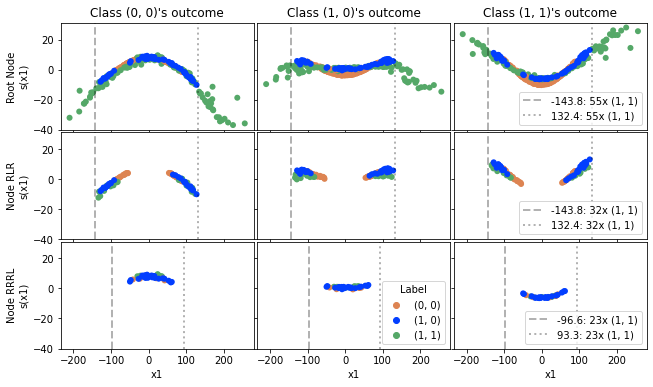

In [21]:
plot_dependence_curves_for_nodes(node, node1, node2,
                                 feature='x1', labels=classes, show_legend=False)
axs = plt.gca().figure.axes
ax = axs[2]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[5]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[8]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[7]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), loc='lower right', title='Label')
plt.savefig('figures/gaussian-depplots-10-x1.pdf', bbox_inches='tight', pad_inches=0)

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


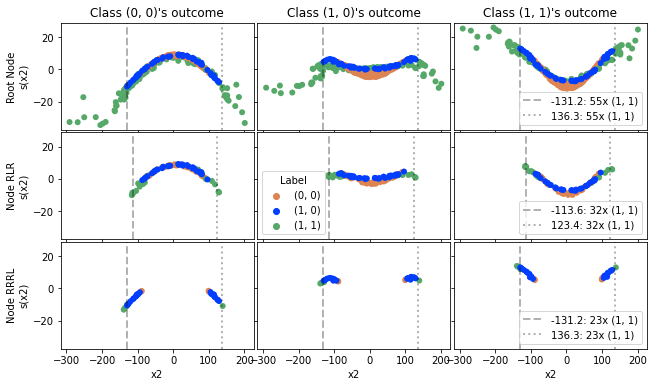

In [24]:
plot_dependence_curves_for_nodes(node, node1, node2,
                                 feature='x2', labels=classes, show_legend=False)
axs = plt.gca().figure.axes
ax = axs[2]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[5]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[8]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[4]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), loc='lower left', title='Label')
plt.savefig('figures/gaussian-depplots-10-x2.pdf', bbox_inches='tight', pad_inches=0)

Node RLR contains most instances where B underestimates the effect of $x_1$ compared to A and node RRRL those, where B underestimates the effect of $x_2$.

In [43]:
pd.DataFrame(node1.diff_shap_values[node1.highlight, :, '1'].values, columns=feature_names).describe()

,x1,x2
count,32.000000,32.000000
mean,-1.266764,0.809979
std,0.657802,0.621900
min,-2.511475,-0.443559
25%,-1.739308,0.452660
50%,-1.416732,0.843670
75%,-0.913912,1.350107
max,0.257790,1.868075


In [44]:
pd.DataFrame(node2.diff_shap_values[node2.highlight, :, '1'].values, columns=feature_names).describe()

,x1,x2
count,23.000000,23.000000
mean,1.249349,-1.613665
std,0.407777,0.454388
min,0.440795,-2.288140
25%,1.069109,-2.019989
50%,1.321797,-1.708729
75%,1.578197,-1.160954
max,1.906372,-0.827527


In [29]:
from clustering import plot_indiv_dependence_curve_comparison_for_feature

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


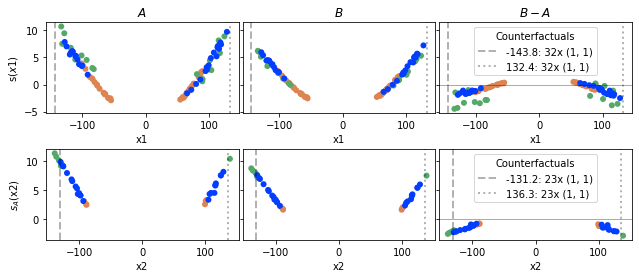

In [36]:
figsize = _DEFAULT_FIGSIZE
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3*figsize[0], 2*figsize[1]), squeeze=False, constrained_layout=True, sharex='row', sharey='row')
plot_indiv_dependence_curve_comparison_for_feature(node1, 'x1', ['1'], axs=axs[0:1].T, show_legend=False, adjust=False)
plot_indiv_dependence_curve_comparison_for_feature(node2, 'x2', ['1'], axs=axs[1:2].T, show_legend=False, adjust=False)
axs = plt.gca().figure.axes
axs[0].set_ylabel('s($x1$)')
axs[0].set_title('$A$')
axs[1].set_title('$B$')
axs[2].set_title('$B-A$')
axs[3].set_title(None)
plt.subplots_adjust(wspace=.02, hspace=.4)
plt.savefig('figures/gaussian-indiv-depplots-local.pdf', bbox_inches='tight', pad_inches=0)

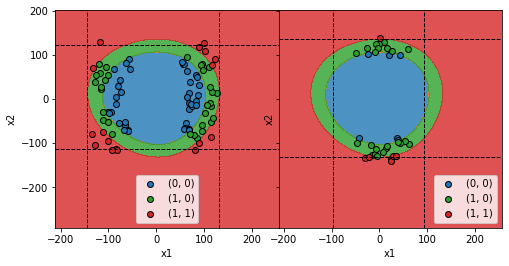

In [45]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4), sharex='all', sharey='all')
plot_2d_with_boundaries(node1, fig=fig, ax=axs[0])
plot_2d_with_boundaries(node2, fig=fig, ax=axs[1])
plt.subplots_adjust(wspace=.0, hspace=.0)
plt.savefig('figures/gaussian-10-level1-instances.pdf', bbox_inches='tight', pad_inches=0)

In [46]:
node1_1 = node1.filter('x1 < 0')
node1_2 = node1.filter('x1 >= 0')

In [47]:
node2_1 = node2.filter('x2 < 0')
node2_2 = node2.filter('x2 >= 0')

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


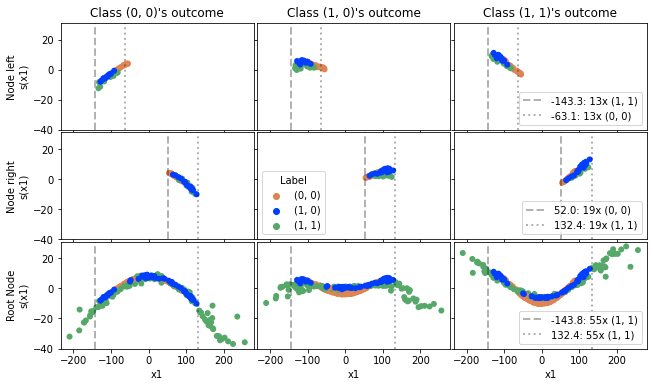

In [48]:
plot_dependence_curves_for_nodes(node, feature='x1', labels=classes, left=node1_1, right=node1_2, show_legend=False)
axs = plt.gca().figure.axes
ax = axs[2]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[5]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[8]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[4]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), loc='lower left', title='Label')
plt.savefig('figures/gaussian-depplots-10-x1-fix.pdf', bbox_inches='tight', pad_inches=0)

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


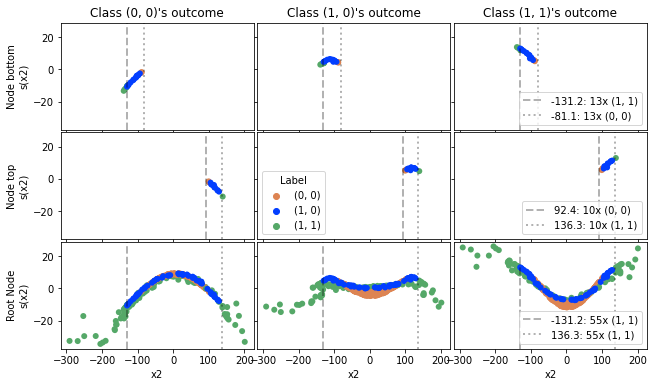

In [51]:
plot_dependence_curves_for_nodes(node, feature='x2', labels=classes, bottom=node2_1, top=node2_2, show_legend=False)
axs = plt.gca().figure.axes
ax = axs[2]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[5]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[8]
ax.get_legend().remove()
ax.legend(*filter_paths(*ax.get_legend_handles_labels()), loc='lower right')
ax = axs[4]
ax.legend(*filter_lines(*ax.get_legend_handles_labels()), loc='lower left', title='Label')
plt.savefig('figures/gaussian-depplots-10-x2-fix.pdf', bbox_inches='tight', pad_inches=0)

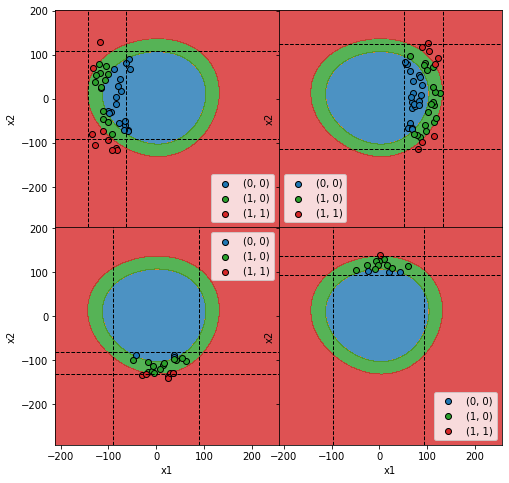

In [50]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), sharex='all', sharey='all')
plot_2d_with_boundaries(node1_1, fig=fig, ax=axs[0][0])
plot_2d_with_boundaries(node1_2, fig=fig, ax=axs[0][1])
plot_2d_with_boundaries(node2_1, fig=fig, ax=axs[1][0])
plot_2d_with_boundaries(node2_2, fig=fig, ax=axs[1][1])
plt.subplots_adjust(wspace=.0, hspace=.0)
plt.savefig('figures/gaussian-10-level1-instances-fix.pdf', bbox_inches='tight', pad_inches=0)

# Evaluation

In [75]:
with open('data/test.pickle', 'rb') as f:
    X_test, y_test = pickle.load(f)

In [56]:
%%time
shap_values_test = generate_shap_explanations(comparer, X_test, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('explanations/test.log_odds.shap', 'wb') as f:
    pickle.dump(shap_values_test, f)

Exact explainer: 10001it [08:19, 19.77it/s]                          


CPU times: user 8min 1s, sys: 5.09 s, total: 8min 6s
Wall time: 8min 20s


In [76]:
with open('explanations/test.log_odds.shap', 'rb') as f:
    shap_values_test = pickle.load(f)

In [82]:
metrics = eval_clusterings(node, X_test, shap_values_test)
metrics.describe()

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Precision,Recall,F1 Score,Support,Label,Nodes,Constraints,Distance
0,0.849245,1.000000,0.918478,4332.0,"(0, 0)",1,4,5281.429304
1,0.865573,0.998846,0.927446,4332.0,"(0, 0)",2,8,1885.917475
2,0.895859,0.998846,0.944554,4332.0,"(0, 0)",3,12,847.983847
3,0.928709,0.998384,0.962287,4332.0,"(0, 0)",4,16,575.764306
4,0.928709,0.998384,0.962287,4332.0,"(0, 0)",5,20,206.512484
...,...,...,...,...,...,...,...,...
189,0.970517,0.399950,0.566462,4033.0,"(1, 1)",58,54,0.614539
190,0.970746,0.403174,0.569727,4033.0,"(1, 1)",59,55,0.519352
191,0.970746,0.403174,0.569727,4033.0,"(1, 1)",60,56,0.302615
192,0.971890,0.402926,0.569676,4033.0,"(1, 1)",61,58,0.003754


In [83]:
metrics[metrics['Label'] == '(0, 1)']

,Precision,Recall,F1 Score,Support,Label,Nodes,Constraints,Distance


In [84]:
grouped_metrics, constraints = group_metrics(metrics, by='Distance', direction='down')
with open('data/fidelity-shap.pickle', 'wb') as f:
    pickle.dump((grouped_metrics, constraints), f)

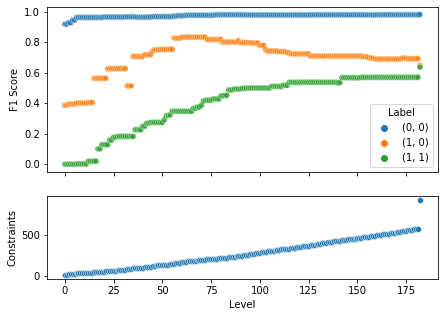

In [85]:
fig, axs = plt.subplots(nrows=2, figsize=(7, 5), sharex='all', gridspec_kw={'height_ratios': [2,1]})
sns.scatterplot(data=grouped_metrics, x='Level', y='F1 Score', hue='Label', alpha=0.8, ax=axs[0])
sns.scatterplot(data=constraints, ax=axs[1])
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

In [64]:
grouped_metrics

Label  Precision    Recall  F1 Score  Support  Nodes     Distance  \
Level                                                                         
0     0  (0, 0)   0.849245  1.000000  0.918478   4332.0    1.0  5281.429304   
      1  (0, 1)   0.000000  0.000000  0.000000      0.0    1.0  5281.429304   
      2  (1, 0)   0.240400  0.999388  0.387571   1635.0    1.0  5281.429304   
      3  (1, 1)   0.000000  0.000000  0.000000   4033.0    1.0  5281.429304   
1     0  (0, 0)   0.849245  1.000000  0.918478   4332.0    1.0  5281.429304   
...         ...        ...       ...       ...      ...    ...          ...   
181   3  (1, 1)   0.971890  0.402926  0.569676   4033.0   61.0     0.003754   
182   0  (0, 0)   0.993849  0.969760  0.981657   4332.0  150.0     0.000000   
      1  (0, 1)   0.000000  0.000000  0.000000      0.0    1.0  5281.429304   
      2  (1, 0)   0.882540  0.510092  0.646512   1635.0   55.0     0.000000   
      3  (1, 1)   0.987493  0.469874  0.636761   4033.0   95.0     0.000000   

         Constraints  
Level                 
0     0          4.0  
      1          0.0  
      2          4.0  
      3          0.0  
1     0          4.0  
...              ...  
181   3         58.0  
182   0        600.0  
      1          0.0  
      2        220.0  
      3        111.0  

[732 rows x 8 columns]

In [63]:
constraints

Level
0       8.0
1      10.0
2      11.0
3      16.0
4      18.0
      ...  
87    189.0
88    190.0
89    192.0
90    194.0
91    297.0
Name: Constraints, Length: 92, dtype: float64

with manual fix:

In [86]:
nodes = [node1_1, node1_2, node2_1, node2_2]

In [39]:
from clustering import eval_clusterings_for_class

In [87]:
eval_clusterings_for_class('(1, 0)', nodes, X_test, shap_values_test)

Precision      0.451163
Recall         0.652599
F1 Score         0.5335
Support          1635.0
Label            (1, 0)
Nodes                 4
Constraints          16
Name: True, dtype: object